Input으로 폴더 경로 지정
-> test 번호 인식하여 그에 맞게 파싱 수행
(각 케이스에 맞게 함수 호출)

In [1950]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

label_MsgSize=['alone', '256B', '512B', '1KB', '2KB', '4KB', '8KB', '16KB', '1MB', '1GB']
label_MTU=['1KB MTU', '2KB MTU', '4KB MTU']

label_Ops=['write', 'send', 'read']
label_Env=['alone', 'competed']
label_Env2=['single', 'multi']
label_Env3=['alone avg', 'competed avg', 'alone 99%', 'competed 99%']
label_Env4=['tput', 'avg. lat', '99% delay']

label_Rate=['1:1', '1:2', '1:4', '1:8', '1:16', '1:32']
label_Rate2=['1:1', '1:2', '1:4', '1:8', '1:16', '1:32', '1:64', '1:128']
label_Size=['1MB', '1GB']
label_TX=['1', '2', '4', '8', '16', '32']

"""
X = label_Ops

Y1=[12, 45]
Y2=[2, 4]
Y3=[3, 5]
df = pd.DataFrame([Y1, Y2, Y3], index=X, columns=label_Env)
print(df)

# fig, ax = plt.subplots(figsize=(12,6))
bar_width=0.4

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
index = np.arange(len(X))
plt.bar(index, df['alone'], bar_width, alpha=0.4, color='red', label='alone')
plt.bar(index + bar_width, df['competed'], bar_width, alpha=0.4, color='blue', label='competed')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
plt.xlabel('Operation', size = 13)
plt.ylabel('Throughput(Mops)', size = 13)
plt.legend()
plt.show()
"""

"\nX = label_Ops\n\nY1=[12, 45]\nY2=[2, 4]\nY3=[3, 5]\ndf = pd.DataFrame([Y1, Y2, Y3], index=X, columns=label_Env)\nprint(df)\n\n# fig, ax = plt.subplots(figsize=(12,6))\nbar_width=0.4\n\n# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정\nindex = np.arange(len(X))\nplt.bar(index, df['alone'], bar_width, alpha=0.4, color='red', label='alone')\nplt.bar(index + bar_width, df['competed'], bar_width, alpha=0.4, color='blue', label='competed')\n\n# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭\nplt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)\nplt.xlabel('Operation', size = 13)\nplt.ylabel('Throughput(Mops)', size = 13)\nplt.legend()\nplt.show()\n"

In [1951]:
""" PARSING FUNCTIONS """
def getBwLines(filepath):
    lines = []
    with open(filepath, "r") as file:
        flag = False
        for idx, line in enumerate(file.readlines()):
            if flag:
                lines.append(line)
            if line.split()[0] == "#bytes":
                flag = True
    return lines

#  0: bytes #iterations  1: t_min[usec]  2: t_max[usec]  3: t_typical[usec]  4: t_avg[usec]  5: t_stdev[usec]   6: 99% percentile[usec]  7: 99.9% percentile[usec]
def getLatLine(filepath):
    with open(filepath, "r") as file:
        flag = False
        for idx, line in enumerate(file.readlines()):
            if flag:
                return line
            if line.split()[0] == "#bytes":
                flag = True
                
    print('There is no result for ' + filepath)
    sys.exit(-1)

# 0:bytes    1: iterations  2: BW peak[Gb/sec]  3: BW average[Gb/sec]  4: MsgRate[Mpps]
def getNthValuesFromBW(fname, n):
    values=[]
    BW_lines = getBwLines(fname)
    for line in BW_lines:
        values.append(float(line.strip().split()[n]))
    
    return values

def getNthValuesFromLat(fname, n):
    line = getLatLine(fname)
    return float(line.strip().split()[n])

def getFileList(path):
    return os.listdir(path)    

### TEST 0
Background Traffic Test

In [1952]:
def runParserType0(test, file_list):
    print('\n##### TEST 0 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_MsgSize
    Y = label_MTU

    # Temp variables for parsing
    X_label = ['0', '256', '512', '1024', '2048', '4096', '8192', '16384', '1048576', '1073741824']
    Y_label = ['1024', '2048', '4096']
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    """ Msg Rate """
    for i, y in enumerate(Y_label):
        for j, x in enumerate(X_label):
            fname = f'write_{y}_{x}_msg'
            
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.plot(index, df[Y[0]], alpha=0.4, color='red', label=Y[0])
    plt.plot(index, df[Y[1]], alpha=0.4, color='blue', label=Y[1])
    plt.plot(index, df[Y[2]], alpha=0.4, color='green', label=Y[2])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(index, X)
    plt.title('Throughput over Background Traffic')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Gbps)', size = 13)
    plt.legend()
    plt.show()
    
    """ Delay """
    for i, y in enumerate(Y_label):
        for j, x in enumerate(X_label):
            fname = f'write_{y}_{x}_lat'
            
            Y_list[j][i] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 5)
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.plot(index, df[Y[0]], alpha=0.4, color='red', label=Y[0])
    plt.plot(index, df[Y[1]], alpha=0.4, color='blue', label=Y[1])
    plt.plot(index, df[Y[2]], alpha=0.4, color='green', label=Y[2])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(index, X)
    plt.title('Latency over Background Traffic')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Latency (us)', size = 13)
    plt.legend()
    plt.show()

### TEST 1
B vs M, D

In [1953]:
# Y1=[123, 456]    #write
# Y2=[2, 4]        #send
# Y3=[3, 5]        #read

def runParserType1(test, file_list):
    print('\n##### TEST 1 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Ops
    Y = label_Env
    
    """ MSG RATE """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, env in enumerate(Y):
        for j, op in enumerate(X):
            fname = f'{op}_{mtu}_{env}_msg'
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label='alone')
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label='competed')

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Throughput when Bw vs Msg')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Mops)', size = 13)
    plt.legend()
    plt.show()
    
            
    """ BW1 """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, env in enumerate(Y):
        for j, op in enumerate(X):
            fname = f'{op}_{mtu}_{env}_bw'
            if env == 'competed':
                fname += '1'
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label='alone')
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label='competed')

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Bandwidth when Bw vs Msg')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Gbps)', size = 13)
    plt.legend()
    plt.show()
    
    
    """ LATENCY """
    X = label_Ops
    Y = label_Env
    Y_label = label_Env3
    Y_list = [[0 for i in range(4)] for j in range(len(X))]
    
    for i, env in enumerate(Y):
        for j, op in enumerate(label_Ops):
            fname = f'{op}_{mtu}_{env}_lat'
            Y_list[j][i] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 5)
            Y_list[j][i+2] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 7)
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y_label)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.15

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y_label[0]], bar_width, alpha=0.4, color='red', label=Y_label[0])
    plt.bar(index + bar_width, df[Y_label[1]], bar_width, alpha=0.4, color='blue', label=Y_label[1])
    plt.bar(index + 2*bar_width, df[Y_label[2]], bar_width, alpha=0.4, color='yellow', label=Y_label[2])
    plt.bar(index + 3*bar_width, df[Y_label[3]], bar_width, alpha=0.4, color='green', label=Y_label[3])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    # plt.xticks(index, X)
    plt.xticks(np.arange(bar_width, len(index)+bar_width, 1), X)
    plt.title('Delay when Bw vs Lat')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Latency (us)', size = 13)
    plt.legend()
    plt.show()
    
    """ BW2 """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, env in enumerate(Y):
        for j, op in enumerate(X):
            fname = f'{op}_{mtu}_{env}_bw'
            if env == 'competed':
                fname += '2'
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label='alone')
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label='competed')

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Bandwidth when Bw vs Lat')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Gbps)', size = 13)
    plt.legend()
    plt.show()

### TEST 2
B vs B
poll

In [1954]:
# 다시짜기 tx size에 따라 바뀌는 경향 실험임
def runParserType2(test, file_list):
    print('\n##### TEST 2 #####')
    print('---> '+test+'\n')

    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_TX
    Y = label_Size
            
    """ Poll """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            fname = f'write_{mtu}_{x}_{y}'
            
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label='alone')
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label='competed')

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Bandwidth when Bw vs Msg')
    plt.xlabel('TX size', size = 13)
    plt.ylabel('Throughput(Gbps)', size = 13)
    plt.legend()
    plt.show()


### TEST 3
B vs Multi B

In [1955]:
def runParserType3(test, file_list):
    print('\n##### TEST 3 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Rate
    Y = label_Env2
            
    """ Poll """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            num = x.split(":")[1]
            fname = f'write_4096_{num}_{y}'
            
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label=Y[0])
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label=Y[1])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Bandwidth when Single B vs Multi B')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Gbps)', size = 13)
    plt.legend()
    plt.show()

### TEST 4
Single M vs Single D

In [1956]:
def runParserType4(test, file_list):
    print('\n##### TEST 4 #####')
    print('---> '+test+'\n')

    X = label_MTU
    Y = label_Env
    
    X_label = ['1024', '2048', '4096']
    
    """ MSG RATE """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y):
        for j, x in enumerate(X_label):
            fname = f'write_{x}_{y}_msg'
            Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label='alone')
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label='competed')

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.ylim(0, 30)
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Tput when Single M vs Single D')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Mops)', size = 13)
    plt.legend()
    plt.show()
    
    
    """ LATENCY """
    X = label_MTU
    Y = label_Env3
    
    Y_list = [[0 for i in range(4)] for j in range(len(X))]
    
    for i, y in enumerate(label_Env):
        for j, x in enumerate(X_label):
            fname = f'write_{x}_{y}_lat'
            Y_list[j][i] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 5)
            Y_list[j][i+2] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 7)
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.15

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label=Y[0])
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label=Y[1])
    plt.bar(index + 2*bar_width, df[Y[1]], bar_width, alpha=0.4, color='yellow', label=Y[2])
    plt.bar(index + 3*bar_width, df[Y[1]], bar_width, alpha=0.4, color='green', label=Y[3])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    # plt.xticks(index, X)
    plt.ylim(0, 5)
    plt.xticks(np.arange(bar_width, len(index)+bar_width, 1), X)
    plt.title('Delay when Single M vs Single D')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Latency (us)', size = 13)
    plt.legend()
    plt.show()

### TEST 5
Single B vs Multi M

In [1957]:
def runParserType5(test, file_list):
    print('\n##### TEST 5 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Rate2
    Y = label_Env2
            
    """ Poll """
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            num = x.split(":")[1]
            fname = f'write_4096_{num}_'
            if y == 'single':
                fname += 'bw'
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            else:
                fname += 'msg'
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)

    fig, ax1 = plt.subplots()
    bar_width=0.4

    ax1.bar(X, df['single'], color='red', alpha=0.4, label=Y[0])
    ax1.set_ylim(0, 100)
    ax1.set_xlabel('QP Num')
    ax1.set_ylabel('Throughput(Gbps)')
    ax1.tick_params(axis='both', direction='in')

    ax2 = ax1.twinx()
    ax2.plot(X, df['multi'], color='blue', alpha=0.4, label=Y[1], linewidth=5)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel(r'Throughput (Mops)')
    ax2.tick_params(axis='y', direction='in')
    
    # 두 그래프의 legend 합치기
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.title('Throughput when Single B vs Multi M')
    plt.show()

### TEST 6
Single M vs Multi M

In [1958]:
def runParserType6(test, file_list):
    print('\n##### TEST 6 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Rate2
    Y = label_Env2
            
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            num = x.split(":")[1]
            fname = f'write_4096_{num}_{y}'
            if y == 'single':
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            else:
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)
    
    # fig, ax = plt.subplots(figsize=(12,6))
    bar_width=0.4

    # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
    index = np.arange(len(X))
    plt.bar(index, df[Y[0]], bar_width, alpha=0.4, color='red', label=Y[0])
    plt.bar(index + bar_width, df[Y[1]], bar_width, alpha=0.4, color='blue', label=Y[1])

    # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 매칭
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Throughput when Single M vs Multi M')
    plt.xlabel('Operation', size = 13)
    plt.ylabel('Throughput(Mops)', size = 13)
    plt.legend()
    plt.show()

### TEST 7
Single D vs Multi M

In [1959]:
def runParserType7(test, file_list):
    print('\n##### TEST 7 #####')
    print('---> '+test+'\n')
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Rate
    Y = label_Env4

    Y_label = ['msg', 'lat']
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y_label):
        for j, x in enumerate(X):
            num = x.split(":")[1]
            fname = f'write_4096_{num}_{y}'
            if y == 'msg':
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 4)[-2]
            elif y == 'lat':
                Y_list[j][i] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 5)
                Y_list[j][i+1] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 7)
            
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)
    
    fig, ax1 = plt.subplots()
    
    index = np.arange(len(X))
    bar_width=0.4
    ax1.bar(index, df[Y[1]], bar_width, color='green', alpha=0.4, label=Y[1])
    ax1.set_ylim(0, 10)
    ax1.set_xlabel('QP Num')
    ax1.set_ylabel('Latency (us)')
    ax1.tick_params(axis='y', direction='in')

    # ax2 = ax1.twinx()
    ax1.bar(index + bar_width, df[Y[2]], bar_width, color='blue', alpha=0.4, label=Y[2])
    
    ax2 = ax1.twinx()
    ax2.plot(X, df[Y[0]], color='red', alpha=0.4, label=Y[0], linewidth=3)
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='both', direction='in')
    
    # 두 그래프의 legend 합치기
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines, labels = ax1.get_legend_handles_labels()
    ax2.legend(lines2 + lines, labels2 + labels, loc='upper left')
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Tput & Delays when Single D vs Multi M')
    plt.show()

### TEST 8
Single D vs Multi B

In [1960]:
def runParserType8(test, file_list):
    print('\n##### TEST 8 #####')
    print('---> '+test+'\n')
    
    mtu=4096
    # index의 종류만큼 list가 있어야함
    # 각 list에는 columns 수 만큼의 데이터 필요
    X = label_Rate
    Y = label_Env4

    Y_label = ['bw', 'lat']
    Y_list = [[0 for i in range(len(Y))] for j in range(len(X))]
    
    for i, y in enumerate(Y_label):
        for j, x in enumerate(X):
            num = x.split(":")[1]
            fname = f'write_4096_{num}_{y}'
            if y == 'bw':
                Y_list[j][i] = getNthValuesFromBW(os.path.join(os.getcwd(), test + '/' + fname), 3)[-2]
            elif y == 'lat':
                Y_list[j][i] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 5)
                Y_list[j][i+1] = getNthValuesFromLat(os.path.join(os.getcwd(), test + '/' + fname), 7)
            
            
    ######### Plot ########
    df = pd.DataFrame(Y_list, index=X, columns=Y)
    print(df)
    
    fig, ax1 = plt.subplots()
    
    index = np.arange(len(X))
    bar_width=0.4
    ax1.bar(index, df[Y[1]], bar_width, color='green', alpha=0.4, label=Y[1])
    ax1.set_ylim(0, 200)
    ax1.set_xlabel('QP Num')
    ax1.set_ylabel('Latency (us)')
    ax1.tick_params(axis='y', direction='in')

    # ax2 = ax1.twinx()
    ax1.bar(index + bar_width, df[Y[2]], bar_width, color='blue', alpha=0.4, label=Y[2])
    
    ax2 = ax1.twinx()
    ax2.plot(X, df[Y[0]], color='red', alpha=0.4, label=Y[0], linewidth=3)
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='both', direction='in')
    
    # 두 그래프의 legend 합치기
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines, labels = ax1.get_legend_handles_labels()
    ax2.legend(lines2 + lines, labels2 + labels, loc='upper left')
    plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
    plt.title('Tput & Delays when Single D vs Multi B')
    plt.show()

In [1961]:
def getTargetFolders(FOLDERS):
    folders=[]
    FOLDERS = os.listdir(os.getcwd())
    print('<Target Folders>')
    for item in FOLDERS:
        sub_folder = os.path.join(os.getcwd(), item)
        if os.path.isdir(sub_folder) and item[:4] == 'test':
            folders.append(item)
            print(item)
    return folders

# error: -1
def runParser(test):
    num = int(test.split('_')[0][4])
    file_list = getFileList(os.path.join(os.getcwd(), test))
    
    if num == 0:
        runParserType0(test, file_list)
    elif num == 1:
        runParserType1(test, file_list)
    elif num == 2:
        runParserType2(test, file_list)
    elif num == 3:
        runParserType3(test, file_list)
    elif num == 4:
        runParserType4(test, file_list)
    elif num == 5:
        runParserType5(test, file_list)
    elif num == 6:
        runParserType6(test, file_list)
    elif num == 7:
        runParserType7(test, file_list)
    elif num == 8:
        runParserType8(test, file_list)
    else:
        print(f'Test Number Parsing Error!: {test}')
        sys.exit(-1)
    

<Target Folders>
test0_202212270351
test1_202212270357
test2_202212270402
test3_202212270403
test4_202212270405
test5_202212270407
test6_202212270408
test7_202212270414
test8_202212270454

##### TEST 0 #####
---> test0_202212270351

         1KB MTU    2KB MTU    4KB MTU
alone  13.954009  13.843104  13.976274
256B   13.419503  13.577230  13.480066
512B   13.124321  13.283644  13.125063
1KB    10.568981  10.514296  10.550541
2KB     8.945142   5.775503   5.794093
4KB     8.635521   5.684583   3.495536
8KB     8.629801   5.679152   3.512621
16KB    8.700615   5.685537   3.492080
1MB     8.666437   5.665211   3.516710
1GB     8.657057   5.658285   3.530389


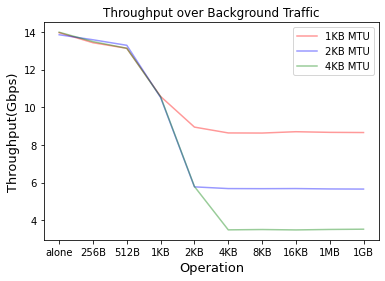

       1KB MTU  2KB MTU  4KB MTU
alone     0.98     0.99     0.99
256B      0.94     0.95     0.95
512B      0.95     0.95     0.94
1KB       2.84     2.82     2.83
2KB       4.28     5.41     5.42
4KB       4.37     5.34     6.22
8KB       4.37     5.34     6.22
16KB      4.36     5.33     6.20
1MB       4.36     5.35     6.20
1GB       4.37     5.36     6.20


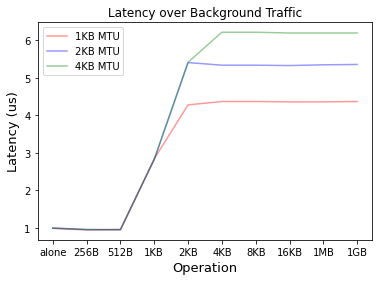


##### TEST 1 #####
---> test1_202212270357

           alone  competed
write  13.926735  3.527702
send   13.933658  3.520683
read    6.880558  1.340462


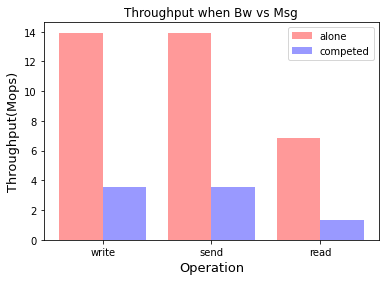

       alone  competed
write  98.04     94.87
send   98.04     95.32
read   98.04     96.97


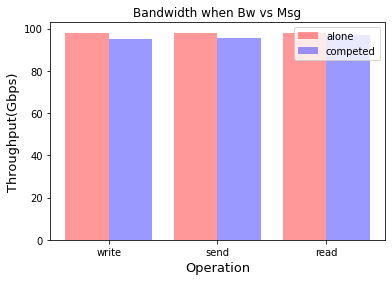

       alone avg  competed avg  alone 99%  competed 99%
write       1.00          6.20       1.19          6.40
send        1.02          6.25       1.24          6.59
read        1.98         12.38       2.29         12.72


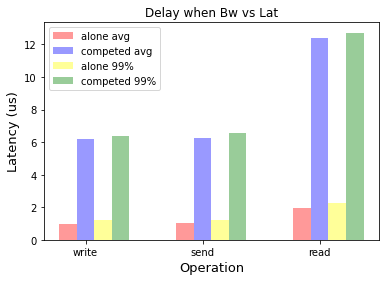

       alone  competed
write  98.04     97.90
send   98.04     97.91
read   98.04     97.97


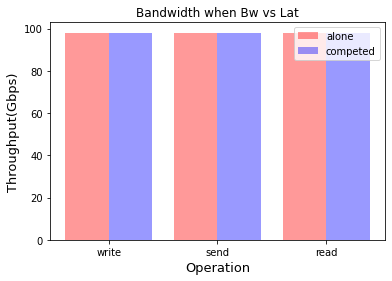


##### TEST 2 #####
---> test2_202212270402

      1MB    1GB
1   45.79  53.26
2   49.02  49.82
4   49.02  49.82
8   49.02  49.82
16  49.02  49.82
32  49.02  49.82


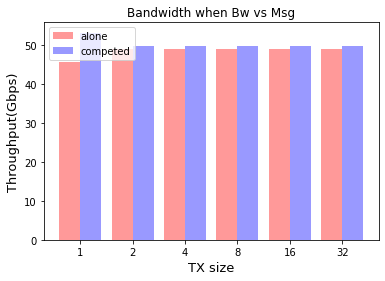


##### TEST 3 #####
---> test3_202212270403

      single  multi
1:1    49.02  49.01
1:2    32.68  65.35
1:4    19.61  78.42
1:8    10.89  87.14
1:16    5.77  92.28
1:32    2.97  95.09


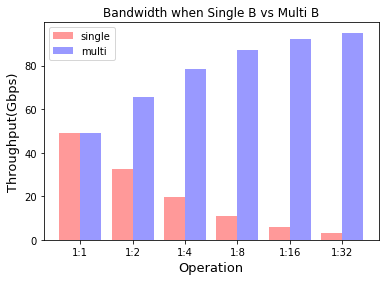


##### TEST 4 #####
---> test4_202212270405

             alone   competed
1KB MTU  13.908888  13.808622
2KB MTU  13.992339  13.844055
4KB MTU  13.928842  13.809040


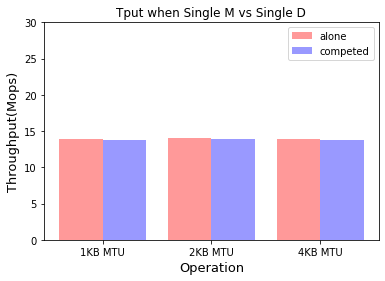

         alone avg  competed avg  alone 99%  competed 99%
1KB MTU       0.99          0.94       1.16          1.15
2KB MTU       0.99          0.93       1.17          1.14
4KB MTU       1.00          0.95       1.20          1.16


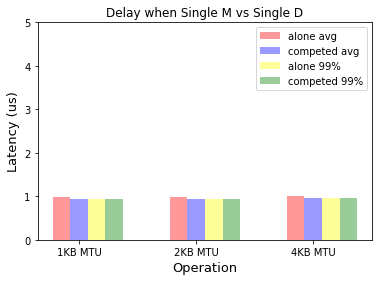


##### TEST 5 #####
---> test5_202212270407

       single      multi
1:1     94.83   3.540523
1:2     92.35   6.267727
1:4     87.81  11.418916
1:8     80.02  20.152718
1:16    69.28  32.200721
1:32    68.90  32.579860
1:64    58.09  46.790277
1:128   41.91  67.677845


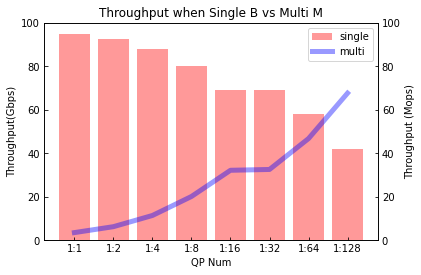


##### TEST 6 #####
---> test6_202212270408

          single       multi
1:1    13.239195   13.239413
1:2    13.708604   27.374821
1:4    13.323603   53.473337
1:8    12.328758   97.291012
1:16    6.856519  102.791547
1:32    4.011623  105.653083
1:64    1.460326  261.036835
1:128   2.228858  108.698973


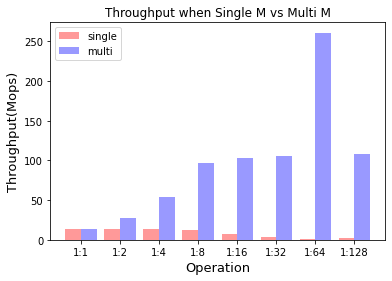


##### TEST 7 #####
---> test7_202212270414

            tput  avg. lat  99% delay
1:1    13.823394      0.94       1.14
1:2    27.386604      0.92       1.13
1:4    53.585697      0.93       1.12
1:8   102.347366      1.00       1.21
1:16  109.060618      1.49       1.67
1:32  109.246290      2.13       1.85


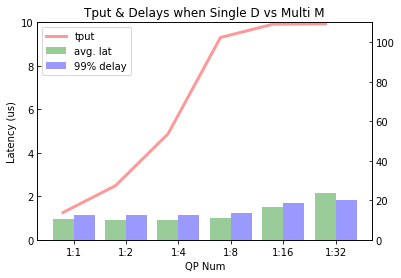


##### TEST 8 #####
---> test8_202212270454

       tput  avg. lat  99% delay
1:1   97.90      6.20       6.39
1:2   97.89      6.34       6.56
1:4   97.91      6.67       6.90
1:8   97.92      6.70       6.94
1:16  97.94      8.40       8.26
1:32  98.02     46.29     136.14


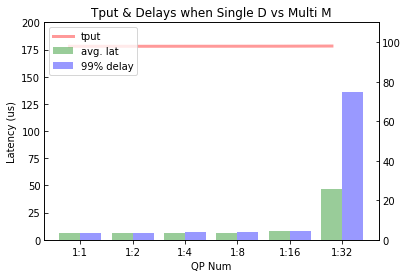

In [1962]:
BASE_DIR = os.getcwd()
TEST_LIST = getTargetFolders(BASE_DIR)

# runParser('test2_202212270334')
for test in TEST_LIST:
    runParser(test)
        

In [1963]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# X = label_Ops

# Y1=[12, 45]
# Y2=[2, 4]
# Y3=[3, 5]
# df = pd.DataFrame([Y1, Y2, Y3], index=X, columns=label_Env)
# print(df)

# # fig, ax = plt.subplots(figsize=(12,6))
# bar_width=0.4

# # 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정
# index = np.arange(len(X))
# plt.bar(index, df['alone'], bar_width, alpha=0.4, color='red', label='alone')
# plt.bar(index + bar_width, df['competed'], bar_width, alpha=0.4, color='blue', label='competed')

# # x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
# plt.xticks(np.arange(bar_width/2, len(index)+bar_width/2, 1), X)
# plt.xlabel('Operation', size = 13)
# plt.ylabel('Throughput(Mops)', size = 13)
# plt.legend()
# plt.show()

In [1964]:
# import matplotlib.pyplot as plt
# import numpy as np

# x = np.arange(3)
# index = np.arrange(len())

# plt.bar(x, values)
# plt.xticks(x, years)

# plt.show()